# Preprocessing & EDA

### Instructions for Thelma

in 'code' I've added a file called 'preprocessingLLM.ipynb'

This notebook:
- loads the preprocessed data
- performs EDA & upsampling
- saves the balanced data to the balanced_dataset.csv


You should perform all the preprocessing, do the train-test split before running the model training code. So we should not rerun train test split for each model.train_test_split

Can you work on this notebook? it should perform the same functions as it does now, but you could add more EDA and explore other techniques to handle the unbalanced data. Upsampling to that degree is unlikely to be the best solution.

In [33]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE

# importing neccessary libraries 
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertPreTrainedModel, BertModel,AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import string
import re
from nltk.corpus import stopwords
import argparse
import logging
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df = pd.read_csv("../data/raw/Womens Clothing E-Commerce Reviews.csv")
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [35]:
df.shape

(23486, 11)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [37]:
# Check for null values in the DataFrame
print(df.isnull().sum())

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [38]:
# Check for null values in the DataFrame
print(df.isnull().sum())

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [39]:
# Function to clean the text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word.lower() not in stop_words)
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|[\w\.-]+@[\w\.-]+', '', text)
    # Remove special characters and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the text
    text = text.lower()
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [40]:
# Define the function to map ratings to sentiment labels
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

In [41]:
# Set the style of seaborn plots
sns.set(style="whitegrid")

In [42]:
PATH_TO_DATA = '../data/processed/customer_reviews.csv'
df = pd.read_csv(PATH_TO_DATA)

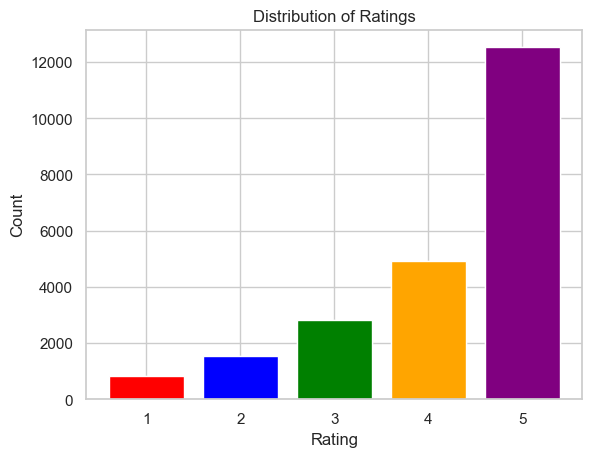

In [43]:
# Defining the x and y values
x = [1, 2, 3, 4, 5]
y = [821, 1549, 2823, 4908, 12527]

# Creating a bar chart of the ratings data
plt.bar(x, y)

# Defining the colors for the bars
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Creating a bar chart with different colors
plt.bar(x, y, color=colors)


# Setting the chart title and axis labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Displaying the chart
plt.show()

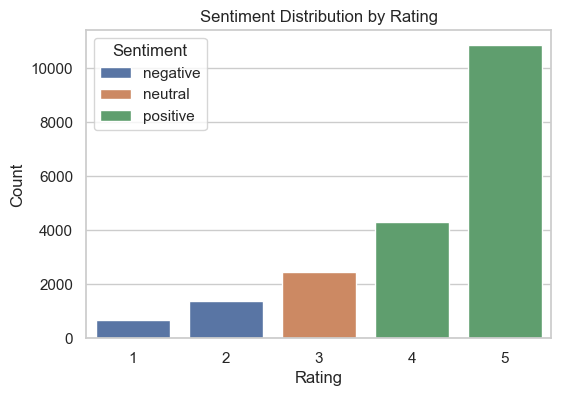

In [44]:
# Sentiment Distribution by Rating
plt.figure(figsize=(6, 4))
sns.countplot(x='Rating', hue='Sentiment', data=df)
plt.title('Sentiment Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

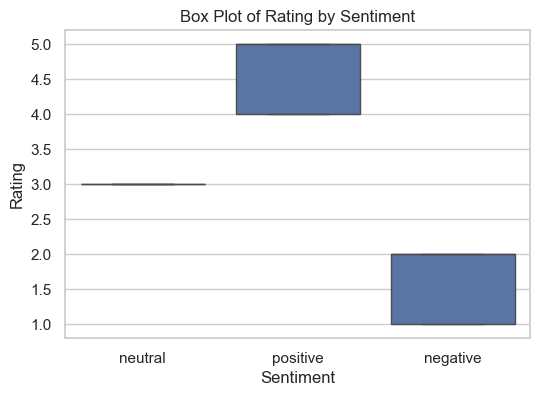

In [45]:
# Box Plot of Rating by Sentiment
plt.figure(figsize=(6, 4))
sns.boxplot(x='Sentiment', y='Rating', data=df)
plt.title('Box Plot of Rating by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.show()

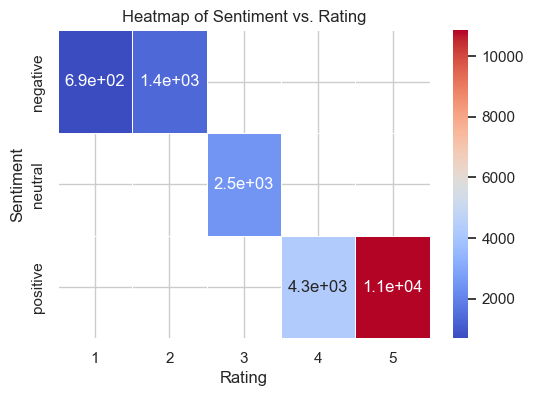

In [46]:
# Heatmap of Sentiment vs. Rating
pivot_table = df.pivot_table(index='Sentiment', columns='Rating', aggfunc='size')
plt.figure(figsize=(6, 4))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Sentiment vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment')
plt.show()

# Model Imbalance

In [47]:
# Define over-sampling parameters
OVER_SAMPLE_SIZE = 17435
over_sampling_strategy = {2: OVER_SAMPLE_SIZE, 1: OVER_SAMPLE_SIZE, 0: OVER_SAMPLE_SIZE}
over_sampler = SMOTE(sampling_strategy=over_sampling_strategy)

# Define under-sampling parameters
UNDER_SAMPLE_SIZE = 2370
under_sampling_strategy = {2: UNDER_SAMPLE_SIZE, 1: UNDER_SAMPLE_SIZE, 0: UNDER_SAMPLE_SIZE}
under_sampler = RandomUnderSampler(sampling_strategy=under_sampling_strategy)

In [48]:
# Print over-sampling parameters
print("Over-sampling parameters:")
print("Sampling strategy:", over_sampling_strategy)

# Print under-sampling parameters
print("\nUnder-sampling parameters:")
print("Sampling strategy:", under_sampling_strategy)

Over-sampling parameters:
Sampling strategy: {2: 17435, 1: 17435, 0: 17435}

Under-sampling parameters:
Sampling strategy: {2: 2370, 1: 2370, 0: 2370}


In [49]:
df.head()
df.shape

X_text = df['Review Text']  # Text data```
y = df['Sentiment']  # Target variable

In [50]:
# Convert sentiment labels to 2, 1, 0
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
y = y.map(label_mapping)

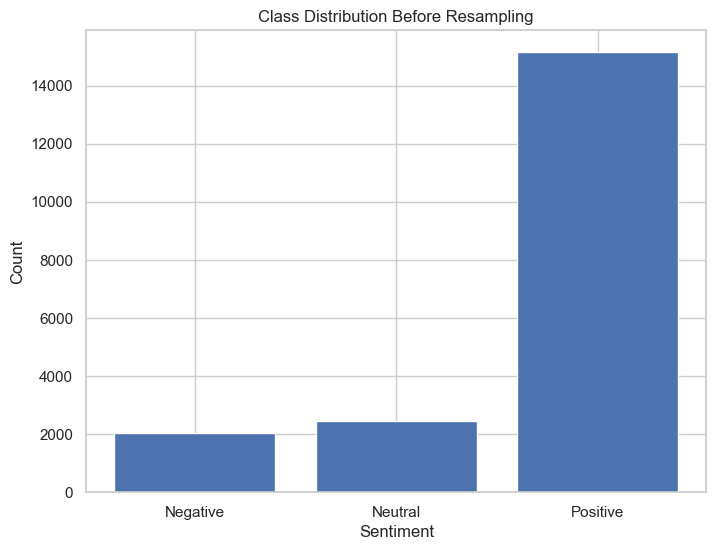

In [51]:
# Visualize the class distribution before resampling
plt.figure(figsize=(8, 6))
plt.bar(Counter(y).keys(), Counter(y).values())
plt.title('Class Distribution Before Resampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.show()

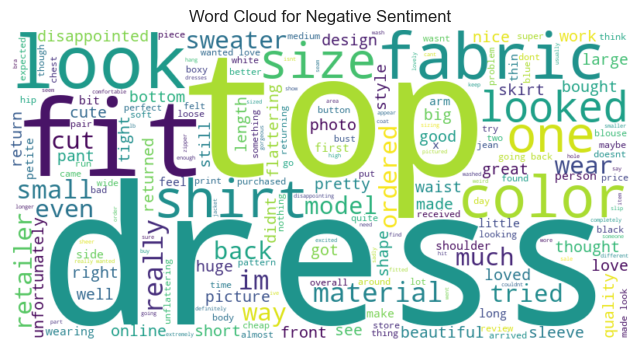

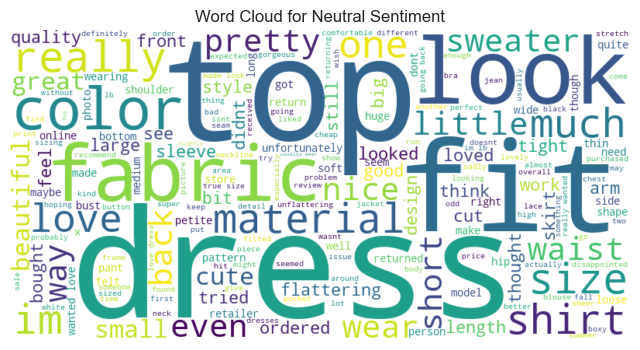

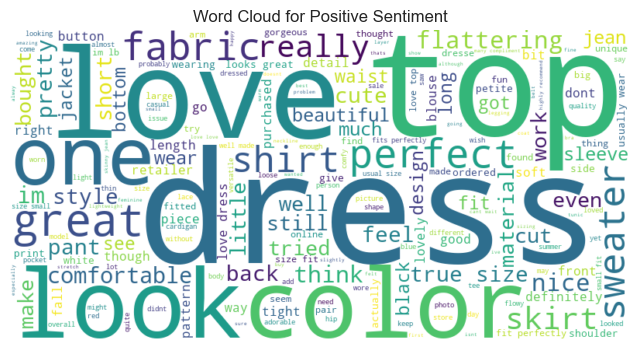

In [52]:
# Create word clouds for each sentiment label
sentiments = ['negative', 'neutral', 'positive']

for sentiment in sentiments:
    # Filter texts by sentiment
    texts = df[df['Sentiment'] == sentiment]['Review Text'].tolist()
    text = ' '.join(texts)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.axis('off')
    plt.show()

In [53]:
df = df.sample(frac=.1, random_state=42).reset_index(drop=True)

In [54]:
# Smaller set for testing
TRAIN_TEST_SPLIT = 0.2
SAMPLE_SIZE = int(df.groupby('Sentiment').size().min() * (1 - TRAIN_TEST_SPLIT))
SAMPLE_SIZE
over_sampling_strategy = {0: SAMPLE_SIZE, 1: SAMPLE_SIZE, 2: SAMPLE_SIZE}
under_sampling_strategy = {0: SAMPLE_SIZE, 1: SAMPLE_SIZE, 2: SAMPLE_SIZE}

In [55]:
# Define the pipeline for TF-IDF transformation
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text data to TF-IDF features
])

# Apply TF-IDF transformation
X_tfidf = tfidf_pipeline.fit_transform(X_text)
# Define the pipeline for resampling
resampling_pipeline = Pipeline([
    ('o', over_sampler),  # Oversample minority classes
    ('u', under_sampler)  # Undersample majority classes
])

In [56]:
# Apply resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_tfidf, y)

In [57]:
# Print the output of each step in the pipeline
print("Output after TF-IDF transformation:")
print(X_resampled)

Output after TF-IDF transformation:
  (0, 10124)	0.0518641766304769
  (0, 2782)	0.04924604405376597
  (0, 8323)	0.05302302636239026
  (0, 384)	0.05854182679744291
  (0, 12086)	0.06219244165774071
  (0, 8672)	0.07407391185572533
  (0, 14593)	0.07629362923083984
  (0, 6157)	0.0725475024641333
  (0, 940)	0.05570434396362889
  (0, 3982)	0.06539077737659975
  (0, 12892)	0.07472219749595223
  (0, 16746)	0.07083679781364385
  (0, 7733)	0.07950626237430256
  (0, 3549)	0.05662736357988392
  (0, 7521)	0.07733453262066585
  (0, 8281)	0.11106802433418768
  (0, 16638)	0.20316850145753626
  (0, 15137)	0.1741576848942768
  (0, 14176)	0.11003555384636916
  (0, 4879)	0.09603248307428534
  (0, 3719)	0.16038392456261855
  (0, 14152)	0.16038392456261855
  (0, 2415)	0.16562286008041868
  (0, 10491)	0.17300672497680558
  (0, 3356)	0.17824566049460577
  :	:
  (7108, 13313)	0.08286543736073436
  (7108, 13573)	0.10515151473064284
  (7109, 7998)	0.2899907258728588
  (7109, 7103)	0.3295782691100344
  (7109, 1365

In [58]:
# Check the class distribution after resampling
print("Over-sampled class distribution:", Counter(y_resampled))

Over-sampled class distribution: Counter({0: 2370, 1: 2370, 2: 2370})


In [59]:
# Convert X_resampled and y_resampled to DataFrame
balanced_df = pd.DataFrame({'Review Text': X_resampled, 'Sentiment': y_resampled})

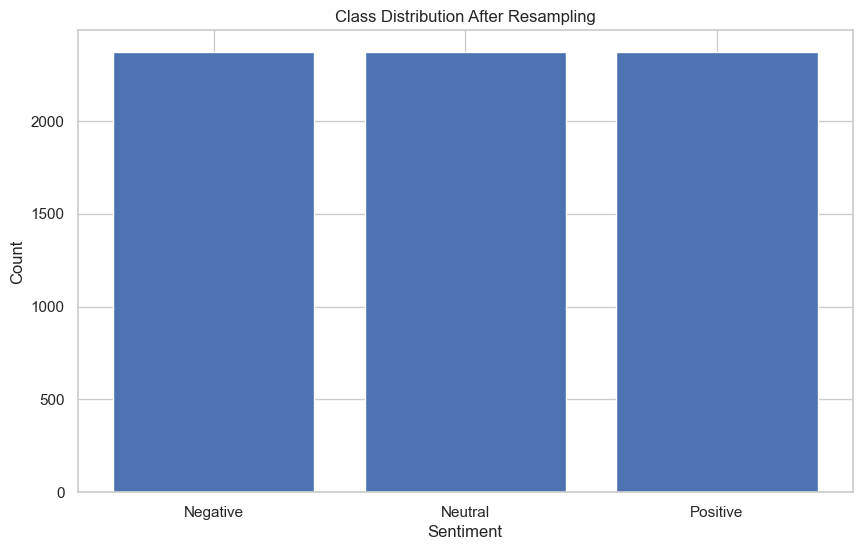

,Review Text,Sentiment
0,"(0, 10124)\t0.0518641766304769\n (0, 2782)\...",0
1,"(0, 5405)\t0.1087195540597835\n (0, 9632)\t...",0
2,"(0, 13313)\t0.036112599883955473\n (0, 1300...",0
3,"(0, 5405)\t0.07026305496894171\n (0, 15290)...",0
4,"(0, 5519)\t0.036257229292146316\n (0, 8124)...",0
...,...,...
7105,"(0, 15306)\t0.19193189822847787\n (0, 1113)...",2
7106,"(0, 7043)\t0.23363297837361013\n (0, 969)\t...",2
7107,"(0, 12874)\t0.30416451052140553\n (0, 10950...",2
7108,"(0, 1493)\t0.26865351890985073\n (0, 15137)...",2


In [60]:
# Visualize the class distribution after resampling
plt.figure(figsize=(10, 6))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title('Class Distribution After Resampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.show()

# Save the balanced dataset as df
# balanced_df.to_csv(/.kaggle/working/womenclothing/balanced_dataset.csv', index=False)
balanced_df

In [61]:
# Get the trained TfidfVectorizer from your TF-IDF pipeline
tfidf_vectorizer = tfidf_pipeline.named_steps['tfidf']

# Convert the TF-IDF transformed data back to the original text format
X_text_original = tfidf_vectorizer.inverse_transform(X_resampled)

# Create a new DataFrame with the original text format
df_original = pd.DataFrame({'Review Text': [' '.join(row) for row in X_text_original], 'Sentiment': y_resampled})

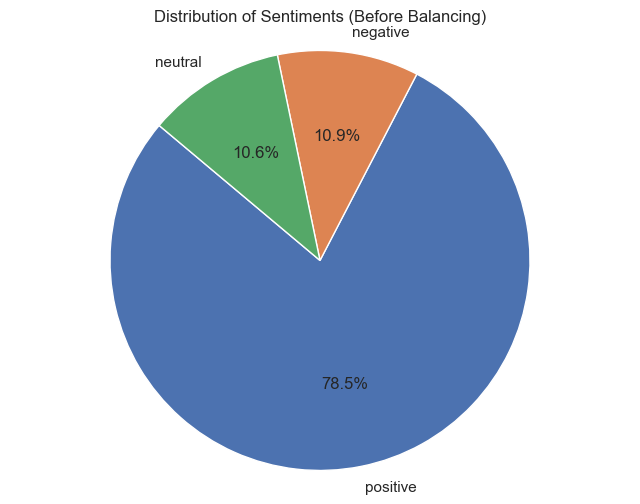

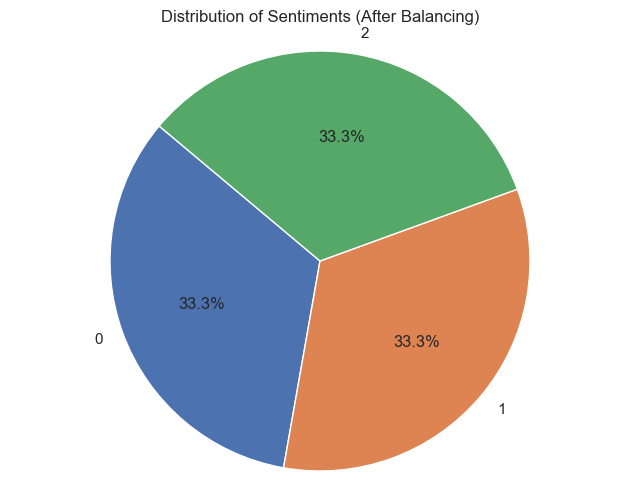

In [62]:
# Data before balancing
sentiment_counts_before = df['Sentiment'].value_counts()

# Plotting pie chart for data before balancing
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts_before.values, labels=sentiment_counts_before.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments (Before Balancing)')
plt.axis('equal') 
plt.show()

# Data after balancing
balanced_sentiment_counts = Counter(y_resampled)

# Plotting pie chart for data after balancing
plt.figure(figsize=(8, 6))
plt.pie(balanced_sentiment_counts.values(), labels=balanced_sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments (After Balancing)')
plt.axis('equal')  
plt.show()

# undersampling

In [63]:
# Undersample the DataFrame
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(df[['Review Text']], df['Sentiment'])

In [64]:
balanced_df = pd.DataFrame({'Review Text': X_resampled['Review Text'], 'Sentiment': y_resampled})

In [65]:
# Data after undersampling
balanced_sentiment_counts = Counter(y_resampled)

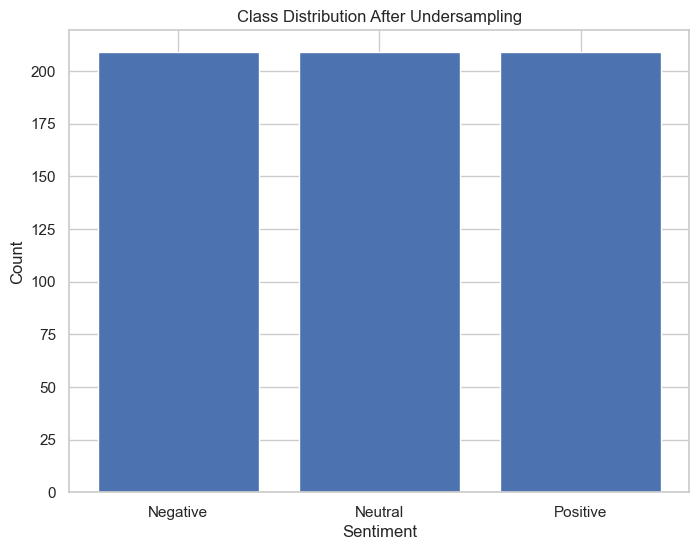

In [66]:
# Plotting pie chart for data after undersampling
plt.figure(figsize=(8, 6))
plt.bar(balanced_sentiment_counts.keys(), balanced_sentiment_counts.values())
plt.title('Class Distribution After Undersampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.show()

In [67]:
# Visualize the class distribution after undersampling
print("Class distribution after undersampling:", balanced_sentiment_counts)

Class distribution after undersampling: Counter({'negative': 209, 'neutral': 209, 'positive': 209})


# Perform Train Test Split (or Train, Test, Validation Split)

In [102]:
# change
X, y = df_original['Review Text'], df_original['Sentiment']

# change to :
X, y = df_original[['Review Text']], df_original[['Sentiment']]



X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.2, random_state=1)

In [103]:
X

,Review Text
0,ordered color little also retailer make sure g...
1,fit nicely tight cheap front well returned loo...
2,size shirt large wanted medium fit tight love ...
3,fit tight layer person underneath type tell bo...
4,flattering length style look like loose fits l...
...,...
7105,tights beading cooler bare legs weather add cl...
7106,identical backwards al bustier flaps sew hook ...
7107,shade pleased arms gray soft jacket short good...
7108,blousy thing romper skin sizing pink appeal da...


# Save Data before Modeling

In [104]:
#OUTPUT_PATH ='/data/train_test/'
#X_train.to_csv(os.path.join(OUTPUT_PATH, 'X_train.csv'), index=False)
#X_test.to_csv(os.path.join(OUTPUT_PATH, 'X_test.csv'), index=False)
#y_train.to_csv(os.path.join(OUTPUT_PATH, 'y_train.csv'), index=False)
#y_test.to_csv(os.path.join(OUTPUT_PATH, 'y_test.csv'), index=False)

In [105]:
from Bert_classifier import (BertWithActivationAndRegularization, Bert_tokenize)
from ML_training_code import (generate_K_Fold_data, torch_tensorize, plot_training_validation, training_loop)

In [106]:
# Config ---------------------------------------->>
PATH_TO_DATA = '../data/train_test/'
SAVE_LOC = '../model-artifacts/'
BATCH_SIZE = 10
DEBUG_MODE = False
EPOCHS = 1
CROSS_VALIDATION = False
K_FOLDS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Config ---------------------------------------->>

# Load data
#X_train = pd.read_csv(PATH_TO_DATA + 'X_train.csv')
#y_train = pd.read_csv(PATH_TO_DATA + 'y_train.csv')
#X_test = pd.read_csv(PATH_TO_DATA + 'X_test.csv')
#y_test = pd.read_csv(PATH_TO_DATA + 'y_test.csv')


# Downsample for testing
if DEBUG_MODE:
    X_train = X_train[:10]
    y_train = y_train[:10]

In [107]:
os.makedirs('./logs', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [108]:
# Specify the pretrained BERT model name
model_name = 'bert-base-uncased'

# Create an instance of the model
model = BertWithActivationAndRegularization(pretrained_model_name='bert-base-uncased', num_labels=3)

# Move the model to GPU if available
model.to(device)

BertWithActivationAndRegularization(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

----
## Training Runtime Hyperparameters
----

In [109]:
# Define the optimizer and criterion
learning_rate = 2e-06
weight_decay = 0.0001  
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

---
## Run without K-Fold Cross Validation
----

In [110]:
# Generate 1 fold
if not CROSS_VALIDATION:
    gkfd = generate_K_Fold_data(X_train, y_train, num_splits=K_FOLDS)
    X_train_fold, y_train_fold, X_val_fold, y_val_fold, train_index, val_index = next(gkfd)

---
## Tokenize
---

In [111]:
X_train_fold

,Review Text
1380,high work medium top fit perfect would like bu...
5999,detachable personally drop matching cotton sna...
6186,picture better much looks fits well top
5305,sweeater msitake nut grey note foot actually s...
6879,simpleness miss bright id liking reference ora...
...,...
905,dress really size overall top love wear great ...
5192,attractive properly versatility piece return m...
3980,nicely cheap love get one color last like stor...
235,wanted work color big doesnt go back shape goo...


In [112]:
if not CROSS_VALIDATION:
    input_ids_train, attention_masks_train, y_train = Bert_tokenize(X_train_fold, y_train_fold)
    input_ids_val, attention_masks_val, y_val = Bert_tokenize(X_val_fold, y_val_fold)

---
## Torch Tensors
---

In [78]:
if not CROSS_VALIDATION:
        (train_dataloader,
        train_dataloader,
        val_dataset,
        val_dataloader) = torch_tensorize(input_ids_train,
                attention_masks_train,
                y_train_fold,
                input_ids_val,
                attention_masks_val,
                y_val_fold,
                BATCH_SIZE=BATCH_SIZE)

---
## Training Loop
---

In [79]:
if not CROSS_VALIDATION:
    # Training loop
    train_losses_fold, valid_losses_fold, accuracies_fold = training_loop(model,
        optimizer,
        criterion,
        train_dataloader,
        val_dataloader,
        device,
        epochs=EPOCHS)

---
## Plot training and validation loss
---

In [80]:
if not CROSS_VALIDATION:
    plot_training_validation(train_losses_fold, valid_losses_fold)

---
## K-Fold Cross-Validation
---

In [84]:
X_train_fold


True

In [81]:
if CROSS_VALIDATION:
    
    # Build generator
    gkfd = generate_K_Fold_data(X_train, y_train, num_splits=K_FOLDS)
    
    results = []
    for i, _gkfd in enumerate(gkfd):
        print(f'Fold {i+1}/{K_FOLDS}')
        X_train_fold, y_train_fold, X_val_fold, y_val_fold, train_index, val_index = _gkfd

        # Tokenize
        input_ids_train, attention_masks_train, y_train = Bert_tokenize(X_train_fold, y_train_fold)
        input_ids_val, attention_masks_val, y_val = Bert_tokenize(X_val_fold, y_val_fold)


        # Create Torch Tensors
        (train_dataloader,
        train_dataloader,
        val_dataset,
        val_dataloader) = torch_tensorize(input_ids_train,
                attention_masks_train,
                y_train_fold,
                input_ids_val,
                attention_masks_val,
                y_val_fold,
                BATCH_SIZE=BATCH_SIZE)

        # Define lists to store metrics for each fold
        train_losses_per_fold = []
        valid_losses_per_fold = []
        accuracies_per_fold = []

        # Training loop
        train_losses_fold, valid_losses_fold, accuracies_fold = training_loop(model,
            optimizer,
            criterion,
            train_dataloader,
            val_dataloader,
            device,
            epochs=EPOCHS)
        
        # Save metrics for this fold
        train_losses_per_fold.append(train_losses_fold)
        valid_losses_per_fold.append(valid_losses_fold)
        accuracies_per_fold.append(accuracies_fold)

        # save results
        results.append({
            'train_losses': train_losses_fold,
            'valid_losses': valid_losses_fold,
            'accuracies': accuracies_fold
        })

Fold 1/5


KeyError: 'Review Text'